<a href="https://colab.research.google.com/github/srigouri/CE888-CausalInference-Assignment2/blob/main/Jobs_Causal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Inference on JOBS Dataset:

---
Description:

 -Using Linear Regression,Logistic Regression with Inverse Propensity Weighting (IPW),Random Forest Regression,Random forest with Inverse Propensity Weighting (IPW), CATE estimator X-Learner with RandomForest as base learner to estimate causal effects in JOBS data.
 (Reference: CE888 Lab4 Task).

 -Hyperparameter optimization using GridSearchCV.

 -Evaluation metrics are called from causalfuncs.py
(Reference: https://github.com/dmachlanski/CE888_2022/blob/main/project/metrics.py)

 -Data source: https://github.com/dmachlanski/CE888_2022/tree/main/project/data


---



#### Packages
Loading Required Packages:

In [90]:
!pip install econml


Importing Libraries:

In [91]:
from econml.metalearners import XLearner
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from causalfuncs import *

#### Data

Loading Jobs data from https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/jobs.csv: using pandas.

In [92]:
jobs_data=pd.read_csv('https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/jobs.csv')

Exploring JOBS data:

In [93]:
jobs_data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,t,y,e
0,-0.614282,1.464727,0.0,0.0,1.0,0.0,2.393250,2.746196,-0.653311,-0.656913,1.627531,2.462337,2.937244,0.0,0.0,2.843909,0.0,0.0,1.0,0.0
1,-0.802463,0.101835,0.0,0.0,1.0,0.0,0.109885,0.498271,-0.785284,-0.743407,-0.022502,-0.177193,0.082537,0.0,0.0,0.038422,0.0,0.0,1.0,0.0
2,-0.896553,-0.238888,1.0,0.0,1.0,1.0,-0.085212,-0.148097,-0.847312,-0.781606,-0.361348,-0.286221,-0.303615,0.0,0.0,-0.191304,0.0,0.0,1.0,0.0
3,-0.896553,-0.238888,0.0,0.0,0.0,1.0,0.405581,0.325594,-0.847312,-0.781606,-0.361348,0.023020,-0.039630,0.0,0.0,0.173108,0.0,0.0,1.0,1.0
4,0.138440,-1.601779,1.0,0.0,1.0,1.0,-0.722531,-0.212734,-0.019840,-0.156019,-1.422084,-0.514563,-0.331552,0.0,0.0,-0.779227,0.0,0.0,1.0,0.0


To check number of rows and columns in JOBS dataset:


In [94]:
jobs_data.shape

JOBS data has got 20 columns in which columns with names x1 to x17 are input features, t denotes for treatment, y is the outcome, and e denotes Effect.The values for particular columns are extracted using integer-location based indexing and
assigning these values to the variables X,T,Yand e respectively.

In [95]:
X=jobs_data[['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17']]
T=jobs_data.iloc[:,17:18].values
Y=jobs_data.iloc[:,18:19].values
e=jobs_data.iloc[:,19:20].values

####Data Pre-processing:

Splitting the Jobs data to Training, validation and testing data.First splitting complete dataset to Training and Testing data in 80/20 ratio.Then again splitting training data to Training and Validation data in 80/20 ratio.

In [96]:
X_train, X_test, T_train, T_test, Y_train, Y_test,e_train,e_test = train_test_split(X, T, Y,e, test_size=0.2)
X_train, X_val,T_train,T_val,Y_train,Y_val,e_train,e_val = train_test_split(X_train,T_train,Y_train,e_train,test_size=0.20)

Checking the shapes of training,Validation,Testing Data


In [97]:
print("X_train shape: {}".format(X_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("X_test shape: {}".format(X_test.shape))
print("T_train shape: {}".format(T_train.shape))
print("T_val shape: {}".format(T_val.shape))
print("T_test shape: {}".format(T_test.shape))
print("Y_train shape: {}".format(Y_train.shape))
print("Y_val shape: {}".format(Y_val.shape))
print("Y_test shape: {}".format(Y_test.shape))
print("e_train shape: {}".format(e_train.shape))
print("e_val shape: {}".format(e_val.shape))
print("e_test shape: {}".format(e_test.shape))

X_train shape: (2055, 17)
X_val shape: (514, 17)
X_test shape: (643, 17)
T_train shape: (2055, 1)
T_val shape: (514, 1)
T_test shape: (643, 1)
Y_train shape: (2055, 1)
Y_val shape: (514, 1)
Y_test shape: (643, 1)
e_train shape: (2055, 1)
e_val shape: (514, 1)
e_test shape: (643, 1)


Plotting histograms of outcome variable,treatment variable and effect variable:


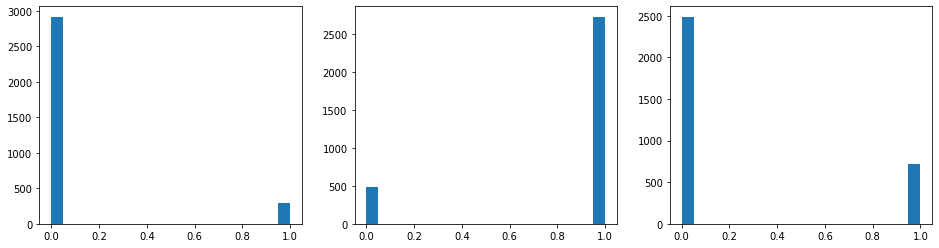

In [98]:
bins=20
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].hist(T, bins=bins)
axs[1].hist(Y, bins=bins)
axs[2].hist(e, bins=bins)
plt.show()

The above histograms of Y, T, e shows that the data is imbalanced.Y, T and e are binary with 0 and 1 as values.

Standardizing the input training data X. No standardization required for treatment variable T as the data is binary.

In [99]:
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_val = scaler_x.transform(X_val)
X_test = scaler_x.transform(X_test)

computing the means of effect in training,validation,test data

In [100]:
np.mean(e_train),np.mean(e_val),np.mean(e_test)

Checking the shape of outcome variable:

In [101]:
Y_train.shape

#### 3.Training the models & Making predictions to compute relevant metrics:
#### 4.Training classifier to predict propensity scores and using same regressors 

####Linear Regression

Training The Model: Using four estimators for training the model:


Concatenating X variable with 25 input features and T i.e treatment 
variable to train the model along with treatment.

Fitting Linear Regressor on training data:


In [102]:
lr = LinearRegression()
XT_train = np.concatenate((X_train,T_train),axis=1)

lr.fit(XT_train, Y_train.ravel())

#For validation of model, y1_val and y0_val are predicted by setting treatment to 1 and 0 respectively.
#Treatment variable (T=0,T=1) is again merged accordingly with X data.
#Predicted outcomes for both treated and controlled for each individuals as y1_val,y0_val and obtained treatement effect using e= y1-y0.
xt0_val = np.concatenate([X_val, np.zeros_like(T_val)], axis=1)
lr_y0_val = lr.predict(xt0_val)

xt1_val = np.concatenate([X_val, np.ones_like(T_val)], axis=1)
lr_y1_val = lr.predict(xt1_val)

lr_t_val = lr_y1_val - lr_y0_val

#Predictions using Test data:
#y1_test and y0_test are predicted by setting treatment to 1 and 0 respectively.
#Setting T to a 1 and 0 for all individuals using zeros_like and one_like and merge with X_test to obtain effect estimates.
#Outcomes for both treated and controlled for each individuals as y1_test,y0_test and obtained effect using e=y1-y0.

xt0_test = np.concatenate([X_test, np.zeros_like(T_test)], axis=1)
lr_y0_test = lr.predict(xt0_test)

xt1_test = np.concatenate([X_test, np.ones_like(T_test)], axis=1)
lr_y1_test = lr.predict(xt1_test)

lr_e_test = lr_y1_test - lr_y0_test

In [103]:
#Accuracy using Root Mean Squared Error
lr_rmse_test = np.sqrt(mean_squared_error(e_test, lr_e_test))
print(lr_rmse_test)

0.42454452790281144


In [104]:
####Logistic Regression Classifier with Inverse Propensity Score(IPW):

lr_clf = LogisticRegression()
weights = get_ps_weights(lr_clf, X_train, T_train)

lr_ipsw = LinearRegression()

lr_ipsw.fit(XT_train, Y_train.flatten(), sample_weight=weights)

lr_ipsw_y0 = lr_ipsw.predict(xt0_val)
lr_ipsw_y1 = lr_ipsw.predict(xt1_val)

lr_ipsw_e = lr_ipsw_y1 - lr_ipsw_y0

lr_ipsw_y0_test = lr_ipsw.predict(xt0_test)
lr_ipsw_y1_test = lr_ipsw.predict(xt1_test)

lr_ipsw_e_test = lr_ipsw_y1_test - lr_ipsw_y0_test


#### Random Forest Regression


In [105]:
#Fitting Random Forest Regressor on training data:

rf = RandomForestRegressor()
rf.fit(XT_train, Y_train.flatten())

#Using Random Forest Regression model,validating outcomes for both treated and controlled 
#for each individuals as y1_val,y0_val and obtained treatement effect using e= y1-y0.

rf_y0_val = rf.predict(xt0_val)
rf_y1_val = rf.predict(xt1_val)

rf_e_val = rf_y1_val - rf_y0_val


rf_y0_test = rf.predict(xt0_test)
rf_y1_test = rf.predict(xt1_test)

rf_e_test = rf_y1_test - rf_y0_test

#### Hyper-parameter Tuning:

Using GridSearch and RandomForest Classifier.

In [106]:
dt_gs = RandomForestRegressor()

params = {'bootstrap': [True],'max_depth': [1, 2, 5, 10, 20, None], 'max_leaf_nodes': [2, 5, 10, 20, 30, None]}
gs_cv = GridSearchCV(dt_gs, cv=10, param_grid=params,n_jobs = -1)

gs_cv.fit(XT_train,Y_train.ravel())

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [1, 2, 5, 10, 20, None],
                         'max_leaf_nodes': [2, 5, 10, 20, 30, None]})

In [107]:
gs_cv.best_params_

{'bootstrap': True, 'max_depth': 10, 'max_leaf_nodes': 20}

In [108]:
gs_cv.best_score_

In [109]:
gs_cv_y0_test = gs_cv.predict(xt0_test)

gs_cv_y1_test = gs_cv.predict(xt1_test)
gs_cv_pred=gs_cv_y1_test-gs_cv_y0_test

#Accuracy using Root Mean Squared Error
rf_rmse_test = np.sqrt(mean_squared_error(e_test, gs_cv_pred))
print(rf_rmse_test)

0.4527207208997922


####RandomForestClassifier with Inverse Propensity Score(IPW):

Training using RandomForestClassifier extending with with the Inverse Propensity Weighting (IPW),to model unit's probability of receiving the treatment, P(ti|xi). This is a classic binary classification problem using input X,treatment T. P(ti|xi)  is called a propensity score.

To get the sample weights, get_ps_weights function is called from causalfuncs.py which is available at https://github.com/srigouri/CE888-Causal/blob/main/causalfuncs.py

In [110]:
from causalfuncs import get_ps_weights
prop_clf = RandomForestClassifier()
weights = get_ps_weights(prop_clf, X_train, T_train)

rf_ipsw = RandomForestRegressor()
rf_ipsw.fit(XT_train, Y_train.flatten(), sample_weight=weights)

RandomForestRegressor()

In [111]:
rf_ipsw_y0_test =rf_ipsw.predict(xt0_test) 
rf_ipsw_y1_test =rf_ipsw.predict(xt1_test) 

rf_ipsw_e_test = rf_ipsw_y1_test - rf_ipsw_y0_test 


#### 5.X-Learner:
  CATE estimator X-learner is a meta-learner implemented via EconML. Used linear regressors and logistic classifiers to model and predict effect. We need not merge inputs and treatment to train the model. 

In [112]:
xl = XLearner(models=LinearRegression(), propensity_model=LogisticRegression())
xl.fit(Y_train, T_train.flatten(), X=X_train)

xl_e_test = xl.effect(X_test)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


##Evaluation

Metrics Chosen: ϵATT  and  Policy_risk 



In [117]:
# Using 'abs_att' function from causalfuncs.py, Average Treatment Effect on the Treated.
lr_att_test = abs_att(lr_e_test.reshape(-1,1),Y_test,T_test,e_test)
lr_ipsw_att_test = abs_att(lr_ipsw_e_test.reshape(-1,1),Y_test,T_test,e_test)
rf_att_test = abs_att(rf_e_test.reshape(-1,1),Y_test,T_test,e_test)
rf_ipsw_att_test = abs_att(rf_ipsw_e_test.reshape(-1,1),Y_test,T_test,e_test)
xl_att_test = abs_att(xl_e_test.reshape(-1,1),Y_test,T_test,e_test) 

# Using 'policy_risk' function from causalfuncs.py, risk of the policy defined by predicted effect.
lr_pr_test =policy_risk(lr_e_test.reshape(-1,1),Y_test,T_test,e_test) 
lr_ipsw_pr_test =policy_risk(lr_ipsw_e_test.reshape(-1,1),Y_test,T_test,e_test) 
rf_pr_test =policy_risk(rf_e_test.reshape(-1,1),Y_test,T_test,e_test) 
rf_ipsw_pr_test = policy_risk(rf_ipsw_e_test.reshape(-1,1),Y_test,T_test,e_test) 
xl_pr_test = policy_risk(xl_e_test.reshape(-1,1),Y_test,T_test,e_test) 

In [118]:
results = []
results.append(['LR', lr_att_test, lr_pr_test])
results.append(['LR (IPSW)', lr_ipsw_att_test, lr_ipsw_pr_test])
results.append(['RF', rf_att_test, rf_pr_test])
results.append(['RF (IPSW)', rf_ipsw_att_test, rf_ipsw_pr_test])
results.append(['XL', xl_att_test, xl_pr_test])

cols = ['Method', 'ATT test', 'Policy_risk test']

df_jobs = pd.DataFrame(results, columns=cols)
df_jobs

,Method,ATT test,Policy_risk test
0,LR,0.003940,0.177778
1,LR (IPSW),0.025811,0.177778
2,RF,0.109012,0.204235
3,RF (IPSW),0.121242,0.189536
4,XL,0.074166,0.205752


#### Confidence Intervals
Confidence intervals of predicted ATEs

In [120]:
lr_ate_bounds = mean_ci(lr_e_test)
lr_ipsw_ate_bounds = mean_ci(lr_ipsw_e_test)
rf_ate_bounds = mean_ci(rf_e_test)
rf_ipsw_ate_bounds = mean_ci(rf_ipsw_e_test)
xl_ate_bounds = mean_ci(xl_e_test)


results = []
results.append(['LR', lr_ate_bounds[0], lr_ate_bounds[1], lr_ate_bounds[2]])
results.append(['LR (IPSW)', lr_ipsw_ate_bounds[0], lr_ipsw_ate_bounds[1], lr_ipsw_ate_bounds[2]])
results.append(['RF', rf_ate_bounds[0], rf_ate_bounds[1], rf_ate_bounds[2]])
results.append(['RF (IPSW)', rf_ipsw_ate_bounds[0], rf_ipsw_ate_bounds[1], rf_ipsw_ate_bounds[2]])
results.append(['XL', xl_ate_bounds[0], xl_ate_bounds[1], xl_ate_bounds[2]])

cols = ['Method', 'ATE mean', 'CI lower', 'CI upper']

df2 = pd.DataFrame(results, columns=cols)
df2

,Method,ATE mean,CI lower,CI upper
0,LR,0.079646,0.079646,0.079646
1,LR (IPSW),0.057774,0.057774,0.057774
2,RF,-0.035083,-0.050929,-0.019236
3,RF (IPSW),-0.042492,-0.057827,-0.027157
4,XL,-0.003695,[-0.03004872936846091],[0.022657865638128015]


#### Visualizations

Box plot showing treatment effect with different models:


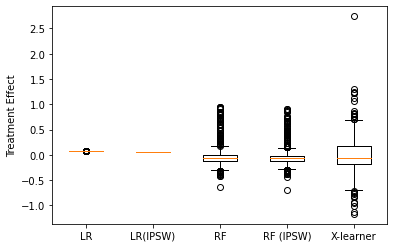

In [121]:
plt.figure()
plt.boxplot([lr_e_test,lr_ipsw_e_test,rf_e_test, rf_ipsw_e_test, xl_e_test.flatten()], labels=['LR','LR(IPSW)','RF', 'RF (IPSW)', 'X-learner'])
plt.ylabel('Treatment Effect')

plt.show()

Scatter plot showing treatment effect with different models:

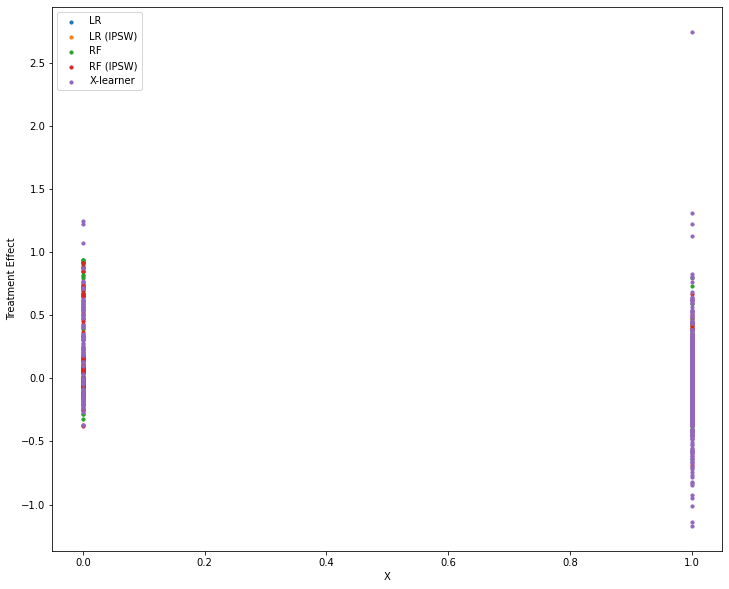

In [122]:
plt.figure(figsize=(12, 10))
m_size = 10
plt.scatter(Y_test,lr_e_test, label="LR", s=m_size)
plt.scatter(Y_test,lr_ipsw_e_test, label="LR (IPSW)", s=m_size)
plt.scatter(Y_test,rf_e_test, label="RF", s=m_size)
plt.scatter(Y_test,rf_ipsw_e_test, label="RF (IPSW)", s=m_size)
plt.scatter(Y_test,xl_e_test, label="X-learner", s=m_size)
plt.xlabel('X')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()